# Basic EDA and Classification


Imports that are going to be required as we go along

In [1]:
from sklearn.datasets import load_files
import pandas as pd
import numpy as np
import os
from nltk.corpus import stopwords
import unidecode
import re
from wordcloud import WordCloud
import matplotlib.pyplot as plt

Reading the cleaned data that has been prepared beforehand in the previous notebook

In [2]:
df = pd.read_csv('cleandata.csv')  
df = df.dropna()
df.head()


,text,label,section,label_name
0,mientras sucedía referido carerás disponiendo ...,1,PAN11,es
1,escribí á v v trasladó rey actual grado clarid...,1,PAN11,es
2,pass silence annoy reader tittle neat perhaps ...,0,PAN11,en
3,cambiaban formas alma permanecía inmóvil inmut...,1,PAN11,es
4,rose bench worked walked hands behind back ges...,0,PAN11,en


Function designed to plot a wordcloud of a given topic/section. It will plot as many wordclouds as languages that section has

In [21]:
def plot_wordcloud_filter(column_name,value,df):
    
    idx = df[column_name]==value
    dfaux = df[idx]
    languages = dfaux["label_name"].unique()
    for lang in languages:
        df2 = dfaux[dfaux["label_name"]==lang]
        wordcloud = WordCloud(width = 500, height = 500,min_font_size = 10).generate(str(" ".join(df2["text"].values)))
        fig = plt.figure(1, figsize=(10, 10))
        plt.axis('off')
        plt.imshow(wordcloud)
        plt.show()



## Wordclouds PAN11

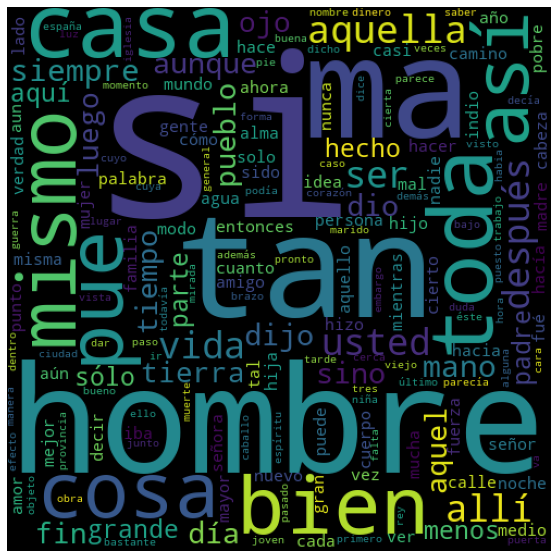

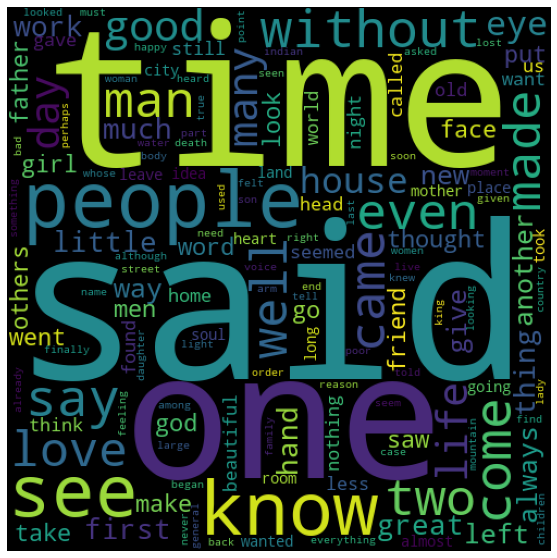

In [22]:
plot_wordcloud_filter("section","PAN11",df)

## Wordclouds APR

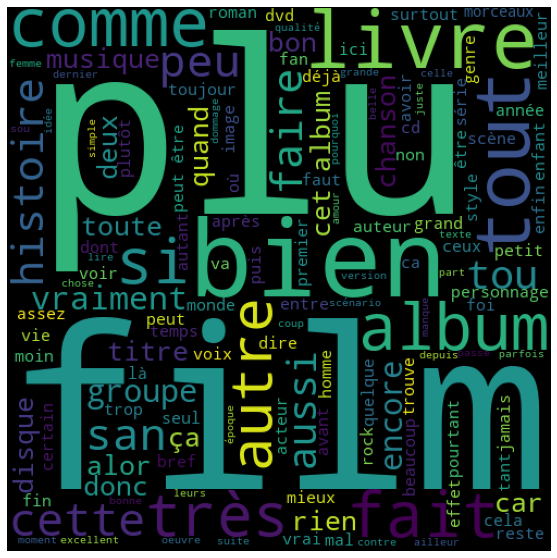

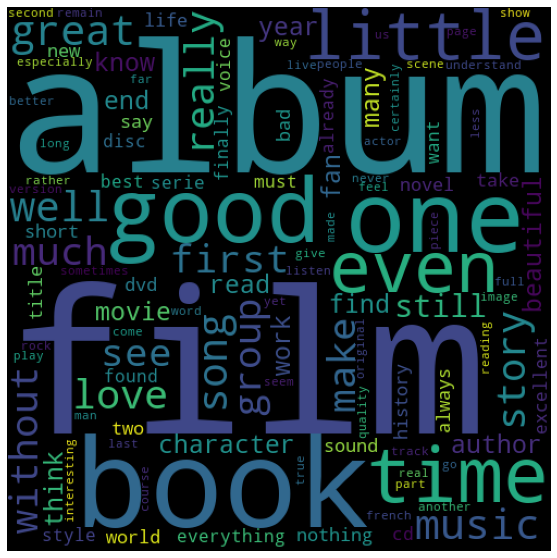

In [4]:
plot_wordcloud_filter("section","APR",df)

## Wordclouds Wikipedia

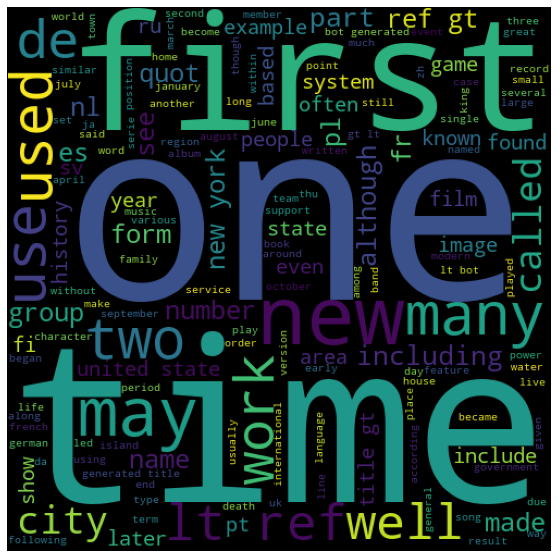

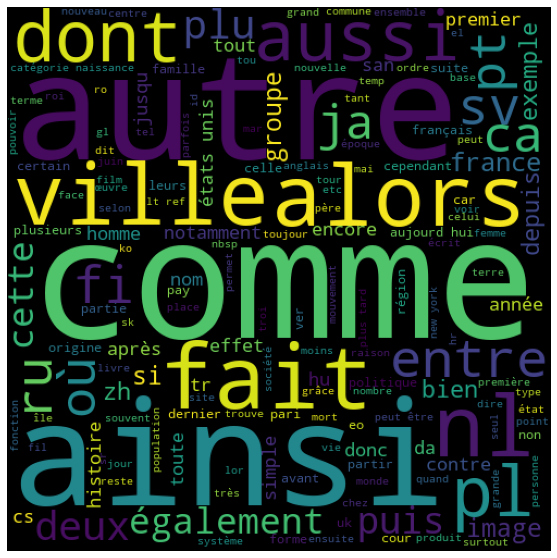

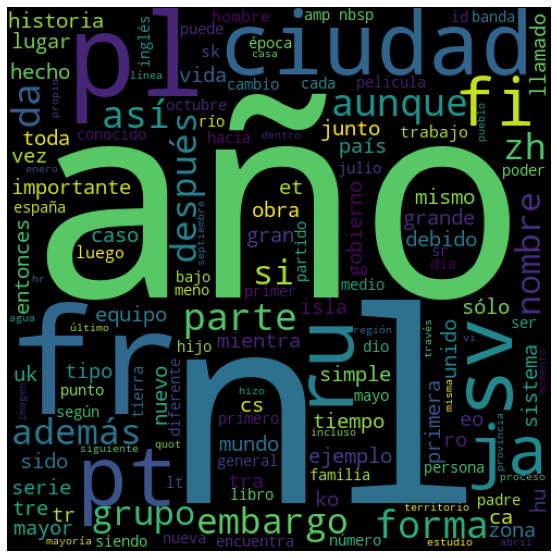

In [5]:
plot_wordcloud_filter("section","Wikipedia",df)

## Wordclouds Conference papers

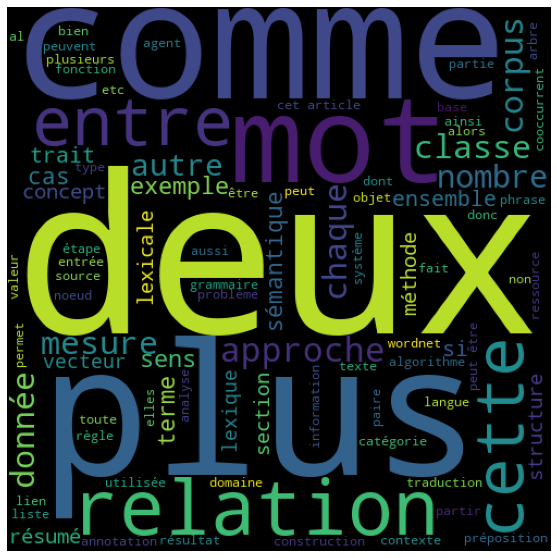

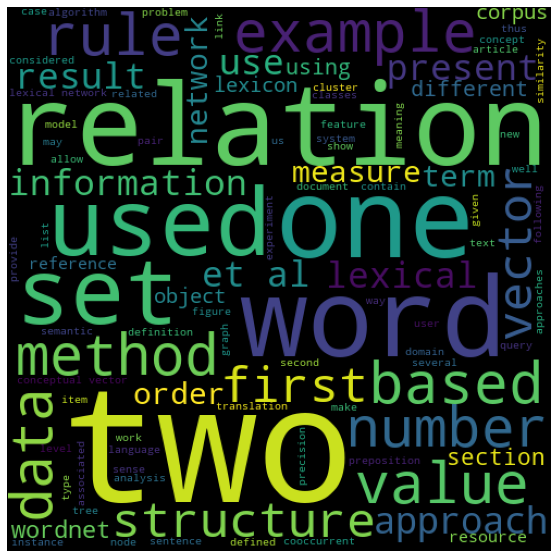

In [6]:
plot_wordcloud_filter("section","Conference_papers",df)

## TF-IDF

### Creating a vocabulary

A common vocabulary is created by getting the 100 most important terms per topic per language, adding up the frquencies in case the whole vocabulary is needed

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer
def get_vocab_by_language(column_name,value,df):
    vocab = {}
    idx = df[column_name]==value
    dfaux = df[idx]
    languages = dfaux["label_name"].unique()
    for lang in languages:
        df2 = dfaux[dfaux["label_name"]==lang]
        tfidfconverter = TfidfVectorizer(max_features=100, min_df=1, max_df=0.9)
        tfidfconverter.fit(df2["text"].values)
        vocab_aux = tfidfconverter.vocabulary_
        for elem in vocab_aux:
            if elem in vocab:
                vocab[elem] = vocab[elem] + vocab_aux[elem]
            else:
                vocab.update({elem : vocab_aux[elem]})
    return vocab


# Check that the function is correct by extracting the vocabulary of one section
vocab_pan = get_vocab_by_language("section","PAN11",df)
vocab_pan

{'fin': 35,
 'tan': 87,
 'vez': 97,
 'luego': 52,
 'mayor': 57,
 'tierra': 89,
 'casi': 17,
 'aquel': 4,
 'dios': 28,
 'vida': 98,
 'días': 33,
 'mano': 54,
 'hacer': 43,
 'mismo': 63,
 'mas': 56,
 'después': 26,
 'amor': 3,
 'parte': 70,
 'día': 32,
 'pueblo': 72,
 'si': 80,
 'allí': 2,
 'camino': 15,
 'tiempo': 88,
 'ser': 77,
 'pues': 75,
 'así': 8,
 'padre': 69,
 'señor': 78,
 'dos': 30,
 'sino': 83,
 'mejor': 59,
 'toda': 90,
 'gente': 37,
 'hizo': 47,
 'san': 76,
 'dar': 24,
 'aunque': 9,
 'cosa': 19,
 'entonces': 34,
 'indios': 51,
 'bien': 12,
 'años': 10,
 'menos': 60,
 'aquí': 7,
 'fué': 36,
 'cosas': 20,
 'mundo': 66,
 'grandes': 39,
 'siempre': 82,
 'cuanto': 21,
 'casa': 16,
 'sólo': 85,
 'hombres': 49,
 'haber': 40,
 'doña': 31,
 'iba': 50,
 'hacía': 45,
 'tres': 92,
 'tal': 86,
 'medio': 58,
 'ahora': 0,
 'alguna': 1,
 'manos': 55,
 'aquella': 5,
 'ciudad': 18,
 'ver': 95,
 'hecho': 46,
 'podía': 71,
 'mal': 53,
 'veces': 94,
 'ojos': 68,
 'gran': 38,
 'mil': 61,
 'todas

Create the common vocabulary for all the sections. With said vocabulary, a classifier will be built

In [8]:
vocab = {}
for section in df["section"].unique():
    vocab_aux = get_vocab_by_language("section",section,df)
    for elem in vocab_aux:
        if elem in vocab:
            vocab[elem] = vocab[elem] + vocab_aux[elem]
        else:
            vocab.update({elem : vocab_aux[elem]})
    

A TFIDF vectorizer is created instantiated with the vocabulary that has previously been prepared

In [9]:
vectorizer = TfidfVectorizer(vocabulary=vocab.keys())

In [10]:
vectorizer.fit(df["text"].values)
X = vectorizer.transform(df["text"].values).toarray()

## Model Training


A model is going to be trained to classify texts into the specified sections. First, data will be split into training and testing

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, df["section"].values, test_size=0.2, random_state=0)

As we are assuming a BOW model, we are going to work with simple models that are based on the principle that word frequencies are not correlated. In this case, we have chosen Random Forest

In [12]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

classifier = RandomForestClassifier(n_estimators=500, random_state=0)  
classifier.fit(X_train, y_train) 
y_pred = classifier.predict(X_test)



print(confusion_matrix(y_test,y_pred))  
print(classification_report(y_test,y_pred))  
print(accuracy_score(y_test, y_pred))



[[1178    3   15    3]
 [   8   92    0    3]
 [  63    0  543    0]
 [   5    0    4 2709]]
                   precision    recall  f1-score   support

              APR       0.94      0.98      0.96      1199
Conference_papers       0.97      0.89      0.93       103
            PAN11       0.97      0.90      0.93       606
        Wikipedia       1.00      1.00      1.00      2718

         accuracy                           0.98      4626
        macro avg       0.97      0.94      0.95      4626
     weighted avg       0.98      0.98      0.98      4626

0.9775183744055339


Results show that the model is able to predict an unseen text's section correctly 97% of the time. This is a high score on such few cleaning steps, which could indicate that our model could be watered down a bit. In that case, a smaller vocabulary and a smaller number of estimators could possibly render a viable model. With more time, these hypothesis should be tested, plotting n_estimators vs accuracy and vocab_size vs accuracy.

### Storing the results

To save the progress that has been achieved,we are storing in files both the model and the vocabulary

In [19]:
import pickle as pic

file = open('classifier_model', 'wb')
pic.dump(classifier,file)
file.close()

In [18]:
file = open('vocab', 'wb')
pic.dump(vocab,file)
file.close()